In [1]:
import sys
sys.path.insert(0, '/mnt/afml/finance_ml')
from finance_ml.datasets import datasets
from finance_ml.features import bars

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

In [3]:
code_list = ['122630', '252670', '233740', '251340']  # 레버리지, 200선물인버스2x, 코스닥150레버리지, 코스닥150선물인버스

In [4]:
code = code_list[2]
date = '2019-03-22'
fname = 'data/{}_{}.csv'.format(code, date)
df = datasets.load_data(code, )
#df.to_csv(fname)

In [5]:
df.head()

,shcode,chetime,price,sign,cvolume
dtime,,,,,
2019-05-10 09:00:11,233740,90011,11495,2,60977
2019-05-10 09:00:11,233740,90011,11490,2,83
2019-05-10 09:00:11,233740,90011,11485,2,450
2019-05-10 09:00:11,233740,90011,11485,2,100
2019-05-10 09:00:11,233740,90011,11485,2,858


In [6]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['price'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['price'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

100%|██████████| 53785/53785 [00:00<00:00, 1087587.40it/s]
/mnt/afml/venv/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


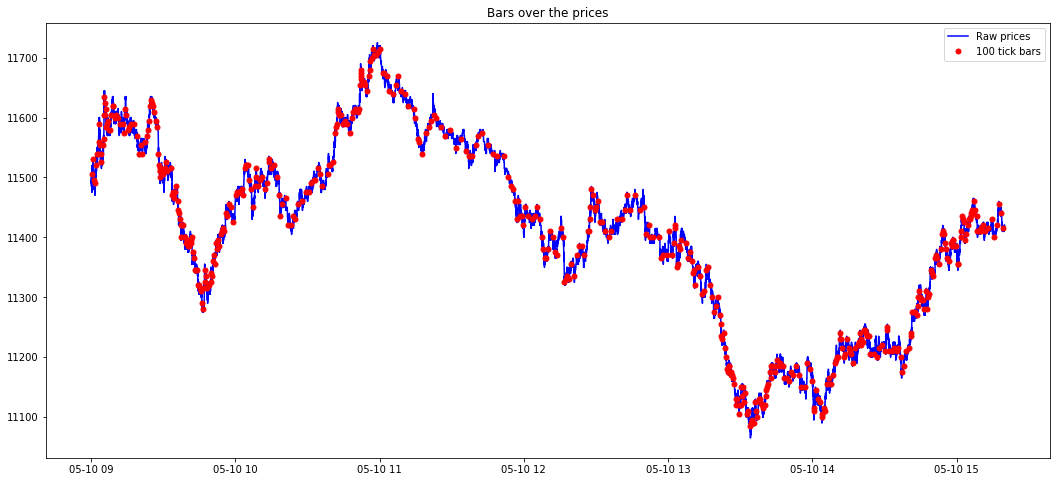

(537, 5)


In [7]:
df_tick = bars.tick_bar_df(df, 'price', 100)
plot_bars(df, df_tick, '100 tick bars')
print(df_tick.shape)

100%|██████████| 53785/53785 [00:00<00:00, 1075675.38it/s]


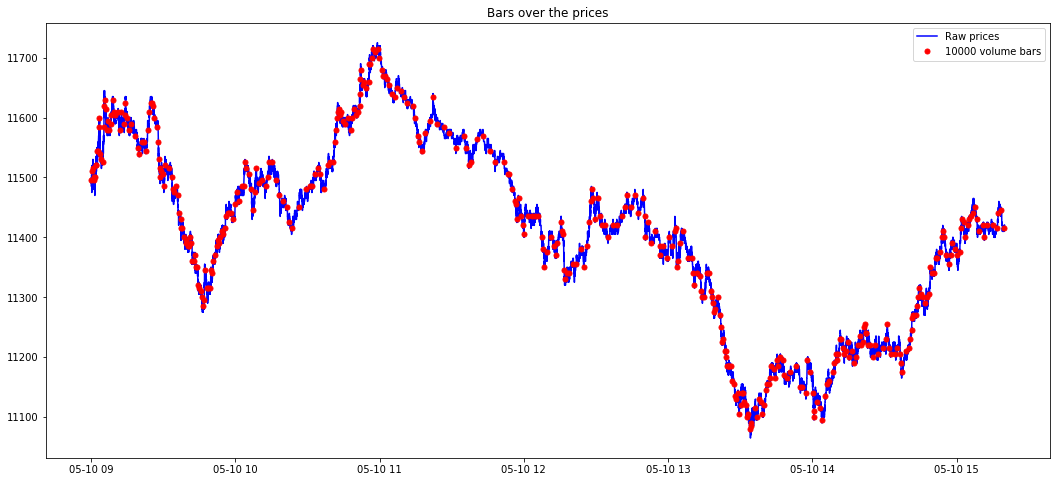

(440, 5)

In [8]:
df_volume = bars.volume_bar_df(df, 'cvolume', 50000)
plot_bars(df, df_volume, '10000 volume bars')
df_volume.shape

100%|██████████| 53785/53785 [00:00<00:00, 986822.75it/s]


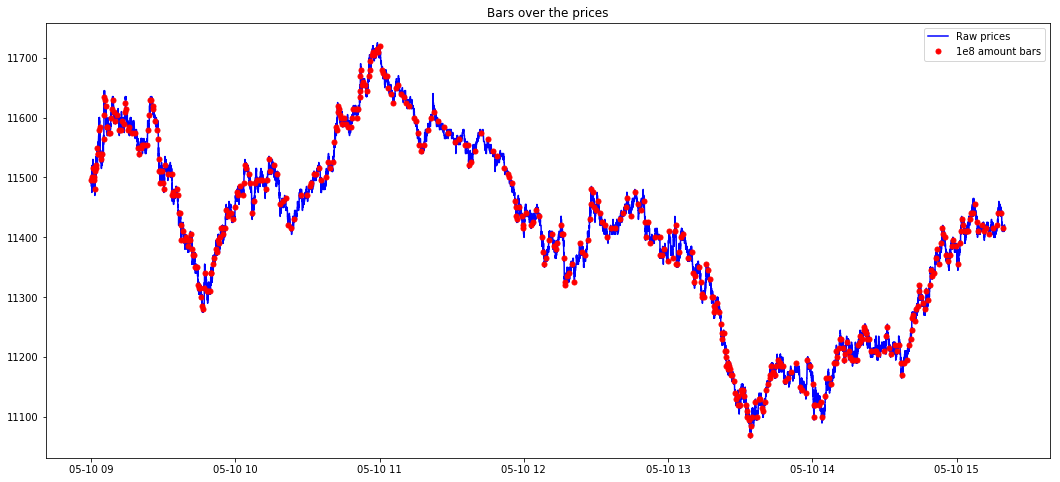

(500, 6)

In [9]:
df['amount'] = df['price']*df['cvolume']
df_dollar = bars.dollar_bar_df(df, 'amount', 5e8)
plot_bars(df, df_dollar, '1e8 amount bars')
df_dollar.shape

100%|██████████| 53785/53785 [00:02<00:00, 20277.61it/s]


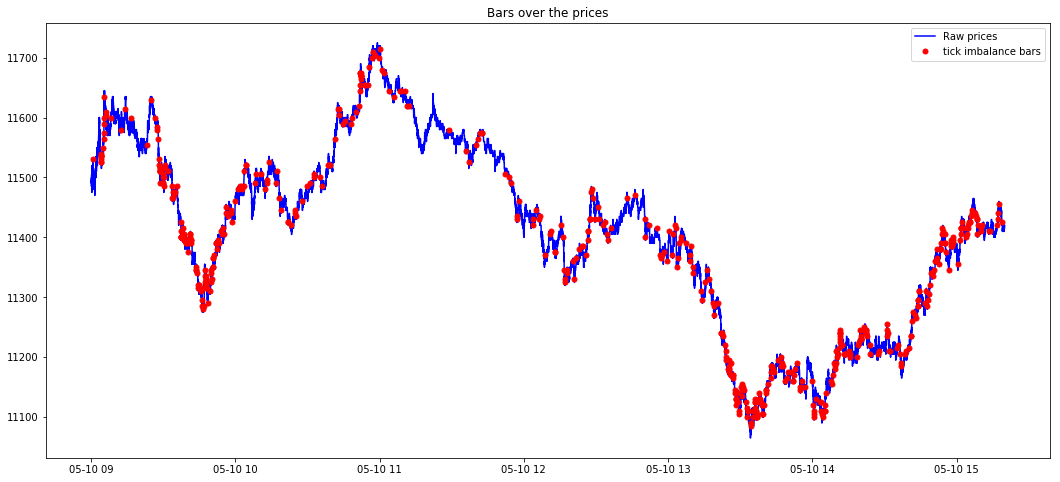

(549, 6)

In [18]:
df_tib = bars.tib_df(df, 'price', 100, 10000)
plot_bars(df, df_tib, 'tick imbalance bars')
df_tib.shape

100%|██████████| 53785/53785 [00:01<00:00, 26922.39it/s]


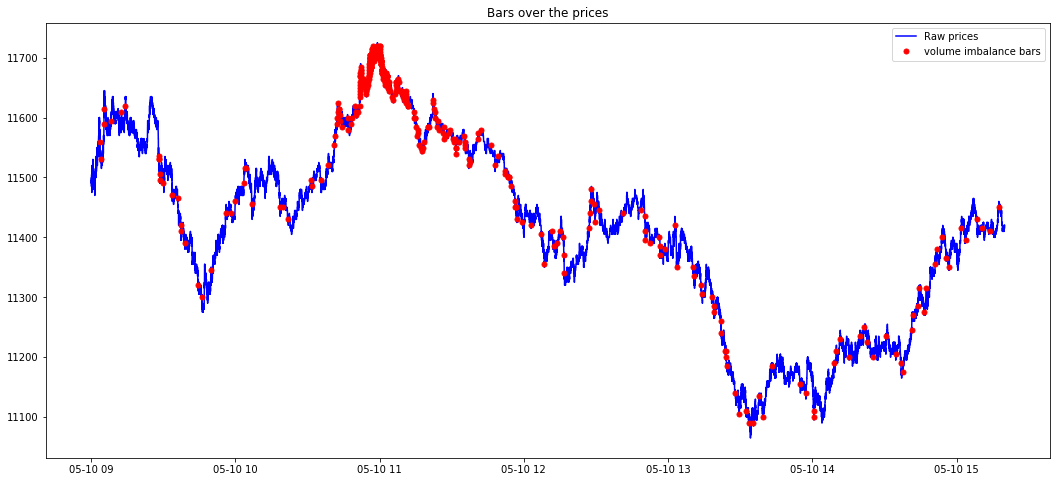

(467, 6)

In [11]:
df_vib = bars.vib_df(df, 'price', 'cvolume', exp_num_ticks_init=1000, num_prev_bars=10000)
plot_bars(df, df_vib, 'volume imbalance bars')
df_vib.shape

In [ ]:
df_trb = trb_df(df, 'price')
print(df_trb.shape)
df_trb.head()

In [ ]:
df_vrb = vrb_df(df, 'price', 'cvolume')
print(df_vrb.shape)
df_vrb.head()